## Assignment to practice CNN and Transfer Learning
### Use dataset provided in Kaggle contest
## Kaggle [link](https://www.kaggle.com/competitions/journey-springfield)

# Import All necessary libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import cv2
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# sns.set(style="darkgrid", font_scale=1.4)

# Let's import data from google drive

## You can find the zip file in [link](https://drive.google.com/file/d/1c28UUMs9XIvC2r9RjWE9qj3vHeytMqm9/view?usp=share_link)

In [2]:
!gdown -q 1c28UUMs9XIvC2r9RjWE9qj3vHeytMqm9

## Let's unzip journey-springfield.zip file

In [4]:
!unzip -q journey-springfield.zip
!rm journey-springfield.zip -rf

# get train dataset
!mv train/simpsons_dataset .
!rm train -rf
!mv simpsons_dataset train

# get test dataset
!mv testset/testset testset/test # rename testset/testet to testset/test
!mv testset test # rename testset to test

You should have these files after unzip:
 - test dir with lots of images
 - train dir with subdirectories with images

  - example: train/abraham_grampa_simpson/pic_XXXX.jpg

- characters_illustration.png
- sample_submission.csv

First two are essential

## Lets look at picture distribution by classes

In [5]:
def get_classes(dir):

  classes = []
  num_files_class = []
  for class_dir in os.listdir(dir):
    num_files = np.sum([1 for f in os.listdir(os.path.join(dir, class_dir))])
    
    classes.append(class_dir)
    num_files_class.append(num_files)

  return pd.Series(num_files_class, index=classes)

In [6]:
train_classes = get_classes('train').sort_values(ascending=False)
train_classes

homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

#### As we can see our dataset is not balanced!

## Let's create Data Transformers


In [7]:
IMAGE_SIZE = (224, 224)
TRAIN_DIR = 'train'
TEST_DIR = 'test'
BATCH_SIZE = 32

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomApply(
            [transforms.CenterCrop(IMAGE_SIZE)],
            p=0.4,
        ),
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Let's create Data Loaders

In [9]:
from sklearn.model_selection import train_test_split

train_dataset = datasets.ImageFolder(TRAIN_DIR, data_transforms['train'])

train_idx, val_idx = train_test_split(range(len(train_dataset)), train_size=0.75)

train_dataloader = {
    'train': DataLoader(
        Subset(train_dataset, train_idx),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
      ),
    'val': DataLoader(
        Subset(train_dataset, val_idx),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
      ),
}

test_dataset = datasets.ImageFolder(TEST_DIR, data_transforms['test'])
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [10]:
classes = train_dataset.classes
n_classes = len(classes)

## Let's see couple of examples of our dataset

### Train dataset (Data Augmentation maybe applied)

In [12]:
def imshow(img, title=None):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.axis('off')
  if title is not None:
    plt.title(title)
  plt.imshow(img)

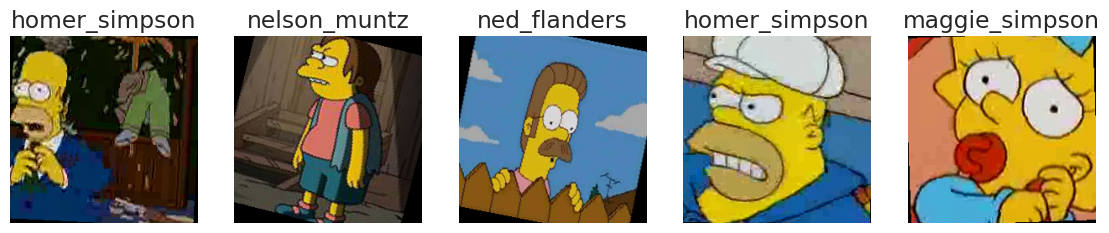

In [40]:
dataloader = train_dataloader['train']
images, labels = next(iter(dataloader))
images, labels = images[:5], labels[:5] # take first 5 from this batch

plt.figure(figsize=(14, 8))
for i in range(len(images)):
  plt.subplot(1, len(images), i+1)
  imshow(images[i], classes[int(labels[i])])
plt.show()

## Finished with dataloading, let's build our Model

### First we will train simple CNN, model than we will try to tune it, or use transferring learning (use pretrained models)

Model architecture:
- input layer: 3x244x244
- First Conv. layer: 8x111x111
- Second Conv. layer: 16x54x54
- Third Conv. layer: 32x12x12
- Fifth Conv. layer: 64x12x12
- Output layer: 96x5x5


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

# Let's Start training our model

## Define all neccessary functions

In [15]:
def train_epoch(model, criterion, optimizer, dataloader, device):
    model.train()

    cur_loss = 0
    total_data = 0

    # for computing accuracy
    cur_correct = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        output_probs = torch.softmax(output, dim=-1)
        preds = output_probs.argmax(-1)

        cur_loss += loss.item() * x_batch.size(0)
        total_data += x_batch.size(0)

        cur_correct += (preds == y_batch).sum().cpu().numpy()

    epoch_loss = cur_loss / total_data
    epoch_acc = cur_correct / total_data

    return epoch_loss, epoch_acc

In [16]:
def eval_epoch(model, criterion, dataloader, device):
    model.eval()

    cur_loss = 0
    total_data = 0

    # for computing accuracy
    cur_correct = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            preds = output.argmax(-1)

        cur_loss += loss.item() * x_batch.size(0)
        total_data += x_batch.size(0)

        cur_correct += (preds == y_batch).sum().cpu().numpy()

    epoch_loss = cur_loss / total_data
    epoch_acc = cur_correct / total_data

    return epoch_loss, epoch_acc

In [17]:
def train(model, epochs, criterion, optimizer, device, dataloaders, lr_scheduler=None):
  history = {}
  model.to(device)
  log_template = "Epoch {:03d}/{:03d}:  train_loss: {:0.5f} | val_loss: {:0.5f} | train_acc: {:0.5f} | val_acc: {:0.5f}"
  for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, dataloaders['train'], device)
    val_loss, val_acc = eval_epoch(model, criterion, dataloaders['val'], device)
    
    print(log_template.format(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))

    history['train_loss'] = history.get('train_loss', []) + [train_loss]
    history['val_loss'] = history.get('val_loss', []) + [val_loss]
    history['train_acc'] = history.get('train_acc', []) + [train_acc]
    history['val_acc'] = history.get('val_acc', []) + [val_acc]
    
    if lr_scheduler is not None:
      lr_scheduler.step(val_loss)
      history['lr'] = history.get('lr', []) + [lr_scheduler._last_lr]

  return history

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logits = []
    targets = []
    for input, target in test_loader:
        input = input.to(device)
        with torch.no_grad():
            outputs = model(input)

        logits.append(outputs.cpu())
        targets.append(target)
    
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    y_pred = np.argmax(probs, -1)
    y_true = torch.cat(targets).numpy()
    return f1_score(y_true, y_pred, average='micro')

In [ ]:
def predict(model, test_loader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logits = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        logits.append(outputs.cpu())
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Start Training


In [44]:
model = SimpleCNN(n_classes)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history = train(
    model=model,
    epochs=30,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    dataloaders=train_dataloader,
)

Epoch 001/030:  train_loss: 2.88283 | val_loss: 2.38013 | train_acc: 0.17657 | val_acc: 0.32060
Epoch 002/030:  train_loss: 1.98506 | val_loss: 1.71448 | train_acc: 0.45194 | val_acc: 0.52809
Epoch 003/030:  train_loss: 1.49032 | val_loss: 1.25210 | train_acc: 0.58953 | val_acc: 0.65380
Epoch 004/030:  train_loss: 1.20047 | val_loss: 1.13662 | train_acc: 0.66170 | val_acc: 0.68418
Epoch 005/030:  train_loss: 1.01734 | val_loss: 0.98675 | train_acc: 0.71527 | val_acc: 0.72870
Epoch 006/030:  train_loss: 0.91069 | val_loss: 0.90599 | train_acc: 0.74737 | val_acc: 0.74551
Epoch 007/030:  train_loss: 0.80064 | val_loss: 0.82431 | train_acc: 0.77572 | val_acc: 0.76806
Epoch 008/030:  train_loss: 0.72503 | val_loss: 0.82410 | train_acc: 0.79273 | val_acc: 0.77971
Epoch 009/030:  train_loss: 0.66303 | val_loss: 0.80104 | train_acc: 0.81400 | val_acc: 0.77665
Epoch 010/030:  train_loss: 0.60415 | val_loss: 0.76898 | train_acc: 0.82629 | val_acc: 0.79499
Epoch 011/030:  train_loss: 0.57144 | va

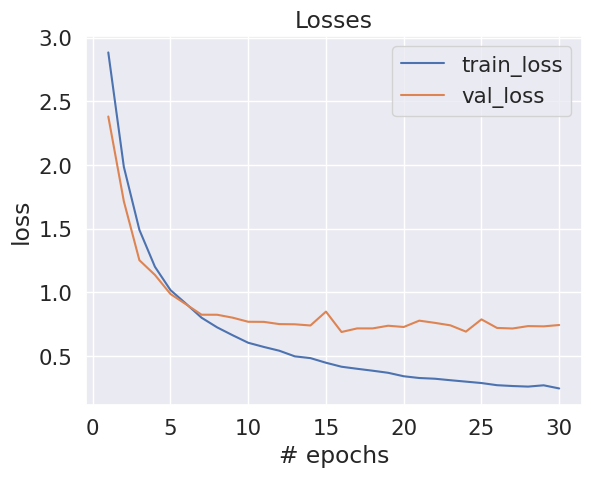

In [45]:
sns.set(style="darkgrid", font_scale=1.4)
n_epochs = len(history['train_loss'])
plt.plot(range(1, n_epochs+1), history['train_loss'], label='train_loss')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='val_loss')
plt.title('Losses')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Let's see what f1_score we got

In [46]:
print(f"f1_score_train: {evaluate(model, train_dataloader['train'])}")
print(f"f1_score_val: {evaluate(model, train_dataloader['val'])}")

f1_score_train: 0.9349003121217911
f1_score_val: 0.8328238440962934


### That's what we get in 30 epochs.
### This model is starting to overfit. We may fix it by adding more regularization and train the model more epochs.

### Let's see what we can get using Transferring Learning

## Lets import EfficientNet pretrained Model

In [20]:
from torchvision.models import efficientnet_b2

model = efficientnet_b2(weights='DEFAULT')
num_features = 1024
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    
    nn.Linear(1408, num_features),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(num_features, n_classes)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 54.7MB/s]


In [21]:
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=3,
    factor=0.7,
    min_lr=0.0001,
)

history = train(
    model=model,
    epochs=30,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    dataloaders=train_dataloader,
    lr_scheduler=lr_scheduler,
)

Epoch 001/030:  train_loss: 0.84498 | val_loss: 0.44835 | train_acc: 0.78871 | val_acc: 0.88384
Epoch 002/030:  train_loss: 0.38894 | val_loss: 0.27040 | train_acc: 0.89948 | val_acc: 0.93217
Epoch 003/030:  train_loss: 0.31599 | val_loss: 0.30493 | train_acc: 0.91668 | val_acc: 0.92300
Epoch 004/030:  train_loss: 0.27232 | val_loss: 0.34690 | train_acc: 0.92993 | val_acc: 0.92549
Epoch 005/030:  train_loss: 0.24403 | val_loss: 0.22048 | train_acc: 0.93738 | val_acc: 0.94402
Epoch 006/030:  train_loss: 0.22577 | val_loss: 0.23619 | train_acc: 0.94082 | val_acc: 0.94383
Epoch 007/030:  train_loss: 0.21281 | val_loss: 0.21886 | train_acc: 0.94573 | val_acc: 0.94765
Epoch 008/030:  train_loss: 0.20953 | val_loss: 0.21873 | train_acc: 0.94535 | val_acc: 0.94593
Epoch 009/030:  train_loss: 0.18507 | val_loss: 0.22587 | train_acc: 0.95216 | val_acc: 0.94574
Epoch 010/030:  train_loss: 0.18844 | val_loss: 0.19463 | train_acc: 0.95159 | val_acc: 0.95472
Epoch 011/030:  train_loss: 0.16624 | va

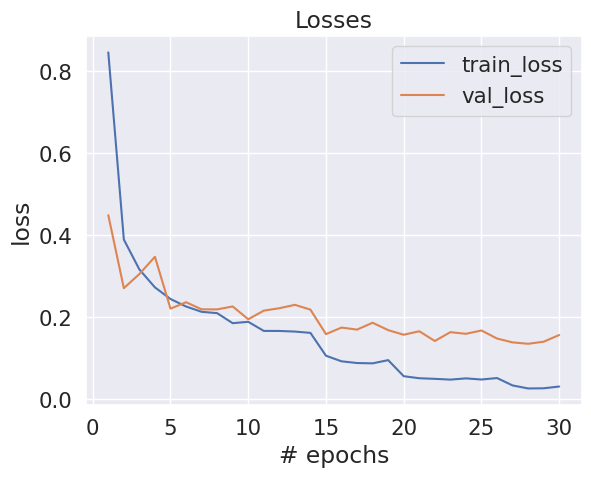

In [22]:
sns.set(style="darkgrid", font_scale=1.4)
n_epochs = len(history['train_loss'])
plt.plot(range(1, n_epochs+1), history['train_loss'], label='train_loss')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='val_loss')
plt.title('Losses')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
torch.save(model.state_dict(), 'tuned_efficientnet_b2')

### Let's see what f1_score we got

In [33]:
print(f"f1_score_train: {evaluate(model, train_dataloader['train'])}")
print(f"f1_score_val: {evaluate(model, train_dataloader['val'])}")

f1_score_train: 0.9966876871138289
f1_score_val: 0.9675200611387086


### Predict test_dataloader

In [34]:
probs = predict(model, test_dataloader)

y_pred = np.argmax(probs, -1)
y_preds = [classes[i] for i in y_pred]

test_filenames = [filename[0].split('/')[-1] for filename in test_dataset.imgs]

In [35]:
submission = pd.read_csv('sample_submission.csv')
submission['Id'] = test_filenames
submission['Expected'] = y_preds
submission

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,milhouse_van_houten
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


In [36]:
submission.to_csv('submission.csv', index=False)

## Got 0.99256 f1_score in Kaggle 🥳

In [37]:
from google.colab import files
files.download('submission.csv') 
files.download('tuned_efficientnet_b2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Download 'tuned_efficientnet_b2' model [here](https://drive.google.com/file/d/1Ej1QpRWVcxGtvlF1nLux0QBs_R0McHPo/view?usp=sharing)